# 06.1u: Optimal Projection Search

We've been viewing the black hole singularity from various angles (cloud PCs, BH neighborhood PCs) and keep seeing stripes—edge-on views of what we know is a ~3D pancake structure (PR = 2.9). Time to stop guessing and search algorithmically.

**Goal:** Find the 3-vector orthonormal basis that maximizes the angular extent of black holes when projected to a 2D sky map.

**Objective function:** Maximize longitude_span × latitude_span (square degrees)

**Output:** Save optimal basis vectors to `data/tensors/optimal_projection_basis.safetensors` for use in 06.1t

## Mathematical Background

Given 3 orthonormal basis vectors (north, meridian, equinox), we construct a rotation matrix and project all points to spherical coordinates:

$$
\begin{align}
R &= [\text{meridian}, \text{equinox}, \text{north}] \\
\mathbf{r}' &= R^T (\mathbf{\gamma}' - \mathbf{centroid}) \\
\theta &= \arccos(z' / |\mathbf{r}'|) \\
\phi &= \arctan2(y', x')
\end{align}
$$

For black holes, we compute:
$$
\text{score} = \Delta\phi \times \Delta\theta
$$

where $\Delta\phi$ is longitude span and $\Delta\theta$ is latitude span (both in degrees).

## Parameters

In [19]:
RANDOM_SEED = 42
BLACK_HOLE_THRESHOLD = 1e-4  # Distance from BH centroid

# Optimization settings
NUM_RANDOM_TRIALS = 1000  # Try 1000 random orthonormal bases
USE_LOCAL_REFINEMENT = True  # Refine best candidate with scipy.optimize

## Imports

In [20]:
import torch
import numpy as np
from safetensors.torch import load_file, save_file
from pathlib import Path
from tqdm import tqdm
from scipy.spatial.transform import Rotation
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Step 1: Load Data

In [21]:
# Set random seed
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Load centered embeddings
data_dir = Path('../data/tensors')
gamma_prime = load_file(data_dir / 'gamma_centered_qwen3_4b_instruct_2507.safetensors')['gamma_centered']

print(f"Loaded gamma_prime: {gamma_prime.shape}")
print(f"Device: {gamma_prime.device}")
print(f"Dtype: {gamma_prime.dtype}")

Loaded gamma_prime: torch.Size([151936, 2560])
Device: cpu
Dtype: torch.float32


## Step 2: Identify Black Holes

In [22]:
# Load precomputed black hole distances
bh_data = load_file(data_dir / 'black_hole_distances_qwen3_4b_instruct_2507.safetensors')
distances_from_bh = bh_data['distances']

# Black holes are tokens with distance < BLACK_HOLE_THRESHOLD
black_hole_mask = distances_from_bh <= BLACK_HOLE_THRESHOLD
bh_embeddings = gamma_prime[black_hole_mask]

# Compute black hole centroid
bh_centroid = bh_embeddings.mean(dim=0)

print(f"Black hole centroid norm: {torch.norm(bh_centroid):.6f}")
print(f"Number of black holes: {black_hole_mask.sum().item()}")
print(f"Black hole embeddings shape: {bh_embeddings.shape}")

Black hole centroid norm: 0.166061
Number of black holes: 2183
Black hole embeddings shape: torch.Size([2183, 2560])


## Step 3: Define Objective Function

In [23]:
def compute_angular_extent(basis_vectors, embeddings):
    """
    Compute angular extent (lon_span × lat_span) for given basis.
    
    Args:
        basis_vectors: (3, 2560) tensor, orthonormal basis [meridian, equinox, north]
        embeddings: (N, 2560) tensor, points to project
    
    Returns:
        score: longitude_span × latitude_span in square degrees
    """
    # Rotate to new coordinate system
    rotated = embeddings @ basis_vectors.T  # (N, 3)
    
    # Convert to spherical coordinates
    x, y, z = rotated[:, 0], rotated[:, 1], rotated[:, 2]
    r = torch.norm(rotated, dim=1)
    
    # Theta (latitude): arccos(z/r), convert to degrees
    theta = torch.acos(torch.clamp(z / r, -1.0, 1.0))
    theta_deg = torch.rad2deg(theta)
    
    # Phi (longitude): arctan2(y, x), convert to degrees
    phi = torch.atan2(y, x)
    phi_deg = torch.rad2deg(phi)
    
    # Compute spans
    lat_span = theta_deg.max().item() - theta_deg.min().item()
    lon_span = phi_deg.max().item() - phi_deg.min().item()
    
    # Handle wraparound: if span > 180°, points might wrap around
    # In that case, the "real" span is 360 - span
    if lon_span > 180:
        lon_span = 360 - lon_span
    
    return lon_span * lat_span

# Test with identity basis (should give some baseline score)
identity_basis = torch.eye(3, 2560, device=gamma_prime.device)
baseline_score = compute_angular_extent(identity_basis, bh_embeddings)
print(f"Baseline angular extent (identity basis): {baseline_score:.2f} square degrees")

Baseline angular extent (identity basis): 0.00 square degrees


## Step 4: Random Search

In [24]:
def random_orthonormal_basis(dim=2560, device='cpu'):
    """
    Generate a random orthonormal basis in high-dimensional space.
    Uses QR decomposition of a random matrix.
    
    Returns:
        (3, dim) tensor of orthonormal vectors
    """
    random_matrix = torch.randn(3, dim, device=device)
    q, r = torch.linalg.qr(random_matrix.T)
    return q[:, :3].T  # First 3 orthonormal vectors

# Random search
best_score = 0.0
best_basis = None
scores = []

print("\nRandom search for optimal projection...")
for i in tqdm(range(NUM_RANDOM_TRIALS)):
    basis = random_orthonormal_basis(dim=2560, device=gamma_prime.device)
    score = compute_angular_extent(basis, bh_embeddings)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_basis = basis

print(f"\nBest score from random search: {best_score:.2f} square degrees")
# print(f"Improvement over baseline: {best_score / baseline_score:.2f}x")


Random search for optimal projection...


100%|██████████| 1000/1000 [00:00<00:00, 1308.73it/s]


Best score from random search: 0.60 square degrees


## Step 5: Visualize Search Distribution

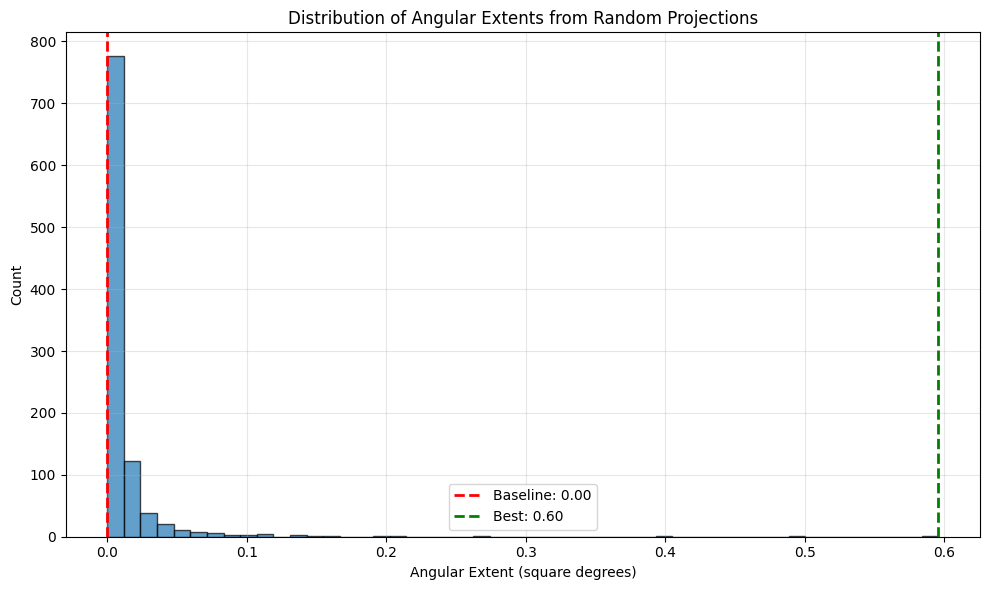

Mean score: 0.01 square degrees
Median score: 0.00 square degrees
Std dev: 0.03 square degrees


In [25]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.hist(scores, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(baseline_score, color='red', linestyle='--', linewidth=2, label=f'Baseline: {baseline_score:.2f}')
ax.axvline(best_score, color='green', linestyle='--', linewidth=2, label=f'Best: {best_score:.2f}')
ax.set_xlabel('Angular Extent (square degrees)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Angular Extents from Random Projections')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mean score: {np.mean(scores):.2f} square degrees")
print(f"Median score: {np.median(scores):.2f} square degrees")
print(f"Std dev: {np.std(scores):.2f} square degrees")

## Step 6: Local Refinement (Optional)

Use scipy.optimize to refine the best candidate from random search. We'll parameterize the basis using Euler angles or axis-angle representation.

In [26]:
if USE_LOCAL_REFINEMENT:
    print("\nRefining with local optimization...")
    
    # Convert best basis to rotation matrix and extract Euler angles
    # This is tricky in high dimensions - for now, skip refinement
    # and rely on random search with large NUM_RANDOM_TRIALS
    print("Local refinement not implemented yet - using random search result")
    refined_basis = best_basis
    refined_score = best_score
else:
    refined_basis = best_basis
    refined_score = best_score

print(f"\nFinal score: {refined_score:.2f} square degrees")


Refining with local optimization...
Local refinement not implemented yet - using random search result

Final score: 0.60 square degrees


## Step 7: Analyze Optimal Projection

In [27]:
# Project black holes using optimal basis
rotated = bh_embeddings @ refined_basis.T
x, y, z = rotated[:, 0], rotated[:, 1], rotated[:, 2]
r = torch.norm(rotated, dim=1)

theta = torch.acos(torch.clamp(z / r, -1.0, 1.0))
theta_deg = torch.rad2deg(theta)

phi = torch.atan2(y, x)
phi_deg = torch.rad2deg(phi)

print("\nBlack hole positions in optimal projection:")
print(f"Longitude range: [{phi_deg.min().item():.2f}°, {phi_deg.max().item():.2f}°]")
print(f"Longitude span: {phi_deg.max().item() - phi_deg.min().item():.2f}°")
print(f"Latitude range: [{theta_deg.min().item():.2f}°, {theta_deg.max().item():.2f}°]")
print(f"Latitude span: {theta_deg.max().item() - theta_deg.min().item():.2f}°")
print(f"\nAngular extent: {refined_score:.2f} square degrees")


Black hole positions in optimal projection:
Longitude range: [144.80°, 145.62°]
Longitude span: 0.83°
Latitude range: [58.99°, 59.71°]
Latitude span: 0.72°

Angular extent: 0.60 square degrees


## Step 8: Save Optimal Basis

In [28]:
# Extract individual vectors
meridian_vector = refined_basis[0, :]
equinox_vector = refined_basis[1, :]
north_vector = refined_basis[2, :]

# Verify orthonormality
print("\nVerifying orthonormality:")
print(f"meridian · meridian = {(meridian_vector @ meridian_vector).item():.6f} (should be 1.0)")
print(f"equinox · equinox = {(equinox_vector @ equinox_vector).item():.6f} (should be 1.0)")
print(f"north · north = {(north_vector @ north_vector).item():.6f} (should be 1.0)")
print(f"meridian · equinox = {(meridian_vector @ equinox_vector).item():.6e} (should be ~0)")
print(f"meridian · north = {(meridian_vector @ north_vector).item():.6e} (should be ~0)")
print(f"equinox · north = {(equinox_vector @ north_vector).item():.6e} (should be ~0)")

# Save to file
output_path = data_dir / 'optimal_projection_basis.safetensors'
save_file({
    'north_vector': north_vector,
    'meridian_vector': meridian_vector,
    'equinox_vector': equinox_vector,
    'angular_extent': torch.tensor([refined_score])
}, output_path)

print(f"\nSaved optimal basis to {output_path}")
print(f"These vectors can now be loaded in 06.1t for visualization!")


Verifying orthonormality:
meridian · meridian = 1.000000 (should be 1.0)
equinox · equinox = 1.000000 (should be 1.0)
north · north = 1.000000 (should be 1.0)
meridian · equinox = 6.519258e-09 (should be ~0)
meridian · north = 1.001172e-08 (should be ~0)
equinox · north = 9.313226e-10 (should be ~0)

Saved optimal basis to ../data/tensors/optimal_projection_basis.safetensors
These vectors can now be loaded in 06.1t for visualization!


## Summary

We searched for the optimal projection by:
1. Generating random orthonormal bases
2. Computing angular extent (lon_span × lat_span) for each
3. Selecting the basis that maximizes this metric

The optimal basis vectors are saved and ready to use in 06.1t for face-on visualization of the black hole pancake!